In [ ]:
pip install nltk


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import necessary libraries
import pandas as pd  # For handling data in DataFrame format

#Natural language processing libraries
import nltk  # For natural language processing tasks(i.e A library for working with human language data)
from nltk.corpus import stopwords  # To access stopwords for text preprocessing
from nltk.stem import WordNetLemmatizer # To reduce words to their base or root form

# Download the list of stopwords from NLTK
nltk.download('stopwords') # Download stopwords data
nltk.download('wordnet')

/var/folders/dm/n6mxv2gx5k16st989zj1sk5m0000gn/T/ipykernel_62698/1118921107.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd  # For handling data in DataFrame format
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sudharshant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sudharshant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Load datasets
train_data = pd.read_csv('train.csv')  # Read the CSV file into a DataFrame
train_data = train_data[['text', 'target']] #select column

test_data = pd.read_csv('test.csv')
# View the first 4 rows of the dataset to understand its structure
train_data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [ ]:
train_data.isnull().sum()

text      0
target    0
dtype: int64

In [ ]:
train_data.duplicated().sum()

92

In [ ]:
train_data.drop_duplicates(keep='first', inplace=True)

In [ ]:
train_data.duplicated().sum()

0

In [ ]:
train_data.shape

(7521, 2)

In [ ]:
train_data.describe()

,target
count,7521.000000
mean,0.426273
std,0.494567
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
print(train_data['target'].unique())

[1 0]


In [ ]:
from sklearn.model_selection import train_test_split  # To split data into training and testing sets
#Train-test split
X = train_data['text']
y = train_data['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=3000)

# Transform the training and testing data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

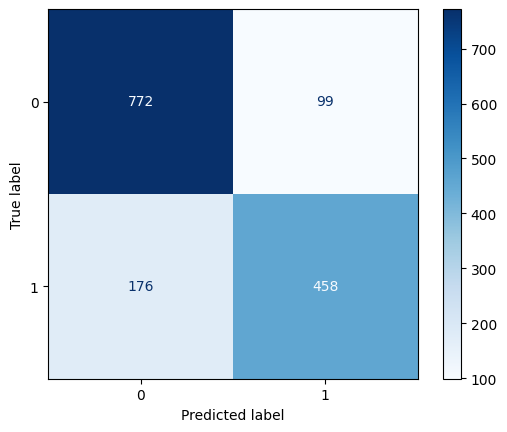

In [ ]:
# Tokenization and embedding extraction using BERT
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set to evaluation mode

# Dataset class to handle text data for BERT
class TextDataset(Dataset):
    def __init__(self, texts, targets=None, tokenizer=None, max_length=128):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        if self.targets is not None:
            target = self.targets.iloc[idx]
            return input_ids, attention_mask, target
        return input_ids, attention_mask

# Prepare datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)

# Function to extract embeddings
def extract_embeddings(dataset):
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, targets = batch
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            # Extract [CLS] token embeddings
            cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            embeddings.extend(cls_embeddings)
            if targets is not None:
                labels.extend(targets.numpy())

    return pd.DataFrame(embeddings), labels

# Extract BERT embeddings for training and validation data
X_train_bert, y_train_bert = extract_embeddings(train_dataset)
X_val_bert, y_val_bert = extract_embeddings(val_dataset)

# Train the SVM model
svm_model = SVC()
svm_model.fit(X_train_bert, y_train_bert)

# Predict on validation data
y_pred = svm_model.predict(X_val_bert)

# Generate and display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
conf_matrix = confusion_matrix(y_val_bert, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues')


In [ ]:
# Step 1: Extract BERT embeddings for train and validation data (reuse previous logic)
X_train_bert, y_train_bert = extract_embeddings(train_dataset)  # Training embeddings
X_val_bert, y_val_bert = extract_embeddings(val_dataset)        # Validation embeddings

# Step 2: Initialize models as before
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier(),
    'Passive Aggressive Classifier': PassiveAggressiveClassifier()
}

# Step 3: Train each model and collect metrics
from sklearn.metrics import f1_score, accuracy_score, classification_report

# Dictionary to store results
bert_results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_bert, y_train_bert)  # Train the model
    y_pred = model.predict(X_val_bert)    # Predict on validation data

    # Evaluate metrics
    f1 = f1_score(y_val_bert, y_pred, average='weighted')  # F1-score
    accuracy = accuracy_score(y_val_bert, y_pred)          # Accuracy

    # Store results
    bert_results[name] = {
        'f1_score': f1,
        'accuracy': accuracy
    }

# Step 4: Display results for BERT-based embeddings
print("\nComparative Analysis with BERT Embeddings:")
for name, metrics in bert_results.items():
    print(f"Model: {name}")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(" ")


Training Logistic Regression...
Training Random Forest...
Training Support Vector Machine...
Training Gradient Boosting...
Training K-Nearest Neighbors...
Training Decision Tree...
Training Neural Network...
Training Extra Trees Classifier...
Training Passive Aggressive Classifier...

Comparative Analysis with BERT Embeddings:
Model: Logistic Regression
  F1-Score: 0.8008
  Accuracy: 0.8013
 
Model: Random Forest
  F1-Score: 0.7663
  Accuracy: 0.7708
 
Model: Support Vector Machine
  F1-Score: 0.8152
  Accuracy: 0.8173
 
Model: Gradient Boosting
  F1-Score: 0.7903
  Accuracy: 0.7920
 
Model: K-Nearest Neighbors
  F1-Score: 0.7555
  Accuracy: 0.7575
 
Model: Decision Tree
  F1-Score: 0.6736
  Accuracy: 0.6731
 
Model: Neural Network
  F1-Score: 0.7961
  Accuracy: 0.7973
 
Model: Extra Trees Classifier
  F1-Score: 0.7668
  Accuracy: 0.7714
 
Model: Passive Aggressive Classifier
  F1-Score: 0.7969
  Accuracy: 0.7960
 


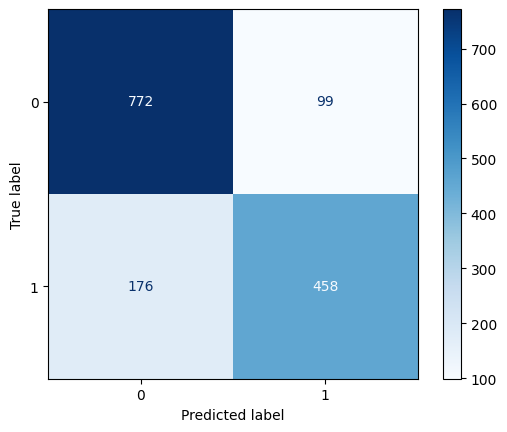

In [ ]:
# Step 1: Use the trained SVM model
svm_model = models['Support Vector Machine']  # Retrieve the SVM model

# Step 2: Predict on the validation set
y_pred_svm = svm_model.predict(X_val_bert)

# Step 3: Generate the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
conf_matrix_svm = confusion_matrix(y_val_bert, y_pred_svm)

# Step 4: Visualize the confusion matrix
disp_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=[0, 1])
disp_svm.plot(cmap='Blues')
